# Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.pipeline import Pipeline
%matplotlib inline

## First feature selection

In [2]:
features = ['gr_liv_area', 'lot_area', 'garage_area', 'total_bath_adj', 'total_bsmt_sf', 'garage_cars', '1st_flr_sf', 'bsmt_qual_1',
'bsmt_qual_2', 'bsmt_qual_3', 'bsmt_qual_4', 'bsmt_qual_5', 'foundation_cblock',
'foundation_pconc', 'foundation_slab', 'foundation_stone', 'foundation_wood', 'mas_vnr_area', 'exter_qual_3',
'exter_qual_4', 'exter_qual_5', 'totrms_abvgrd', 'fireplaces', 'bsmt1_alq', 'bsmt1_blq', 'bsmt1_glq', 'bsmt1_lwq',
'bsmt1_rec', 'bsmt1_unf', 'neighborhood_blueste', 'neighborhood_brdale', 'neighborhood_brkside', 'neighborhood_clearcr',
'neighborhood_collgcr', 'neighborhood_crawfor', 'neighborhood_edwards', 'neighborhood_gilbert',
'neighborhood_greens', 'neighborhood_grnhill', 'neighborhood_idotrr', 'neighborhood_landmrk', 'neighborhood_meadowv',
'neighborhood_mitchel', 'neighborhood_names', 'neighborhood_npkvill', 'neighborhood_nwames',
'neighborhood_noridge', 'neighborhood_nridght', 'neighborhood_oldtown', 'neighborhood_swisu',
'neighborhood_sawyer', 'neighborhood_sawyerw', 'neighborhood_somerst', 'neighborhood_stonebr', 'neighborhood_timber',
'neighborhood_veenker', 'kitchen_qual_2', 'kitchen_qual_3', 'kitchen_qual_4', 'kitchen_qual_5', 'condition', 'heating_gasw',
'heating_grav', 'heating_othw', 'heating_wall', 'heating_gasa', 'heating_qc_fa', 'heating_qc_gd', 'heating_qc_po', 'heating_qc_ta',
'garage_2types', 'garage_attchd', 'garage_basment', 'garage_builtin', 'garage_carport', 'garage_detchd', 'remod_age',
'home_age', 'garage_fin', 'garage_rfn', 'garage_unf']

#list of columns using first as X variables for multiple linear regression

I am starting with a lot of features but will probably need to narrow them down and separate the signal from the noise after checking for multicolinearity and seeing what features are having the most influence

In [3]:
df = pd.read_csv('./cleaned_ames_train_data.csv')
test_df = pd.read_csv('./cleaned_ames_test_data.csv')
test = test_df[features]

#reading in training and testing dataframes

In [4]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.corr()['saleprice'].sort_values(ascending=False)
#checking correlation of X features with target variable (sale price)

saleprice               1.000000
overall_qual            0.800208
quality                 0.787912
total_inside_sf         0.779085
exter_qual              0.712124
gr_liv_area             0.697261
kitchen_qual            0.692587
garage_area             0.650270
garage_cars             0.648220
total_bath_adj          0.630190
total_bsmt_sf           0.629273
1st_flr_sf              0.618451
total_bath              0.609608
bsmt_qual_5             0.586474
year_built              0.571930
kitchen_qual_5          0.551262
year_remod/add          0.550589
fireplace_qu            0.538886
full_bath               0.538211
foundation_pconc        0.529002
totrms_abvgrd           0.503990
mas_vnr_area            0.503530
exter_qual_5            0.493846
fireplaces              0.471034
overall_qual_9          0.470384
bsmt1_glq               0.463491
neighborhood_nridght    0.448623
exter_qual_4            0.446623
bsmtfin_sf_1            0.423920
overall_qual_8          0.422976
garage_fin

## Exploring outliers

I initially thought I would use total bath adjusted and other space and room related features I later decided against.

In [5]:
X = df[features]
y = df['saleprice']

#setting X and y variables

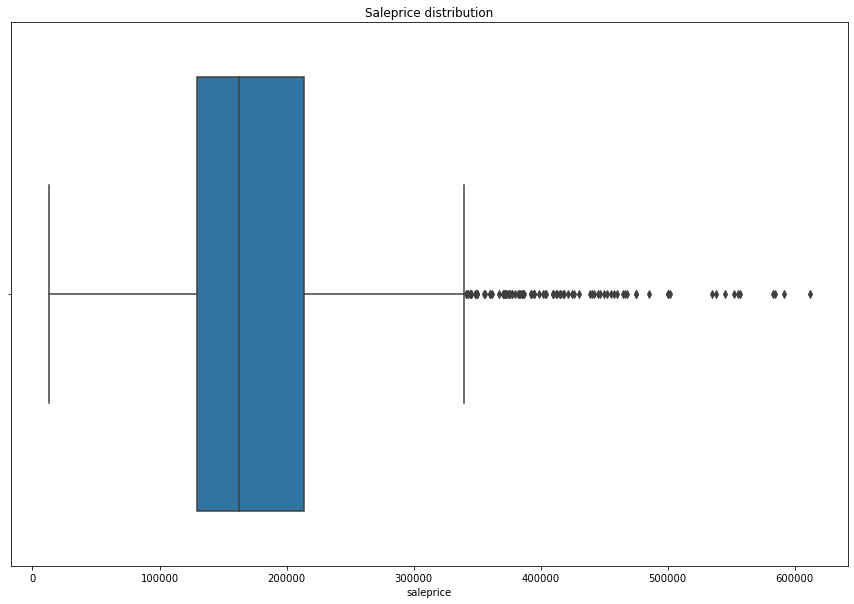

In [6]:
plt.figure(figsize=(15,10))
sns.boxplot(y).set_title('Saleprice distribution');

#boxplot of y variable distribution

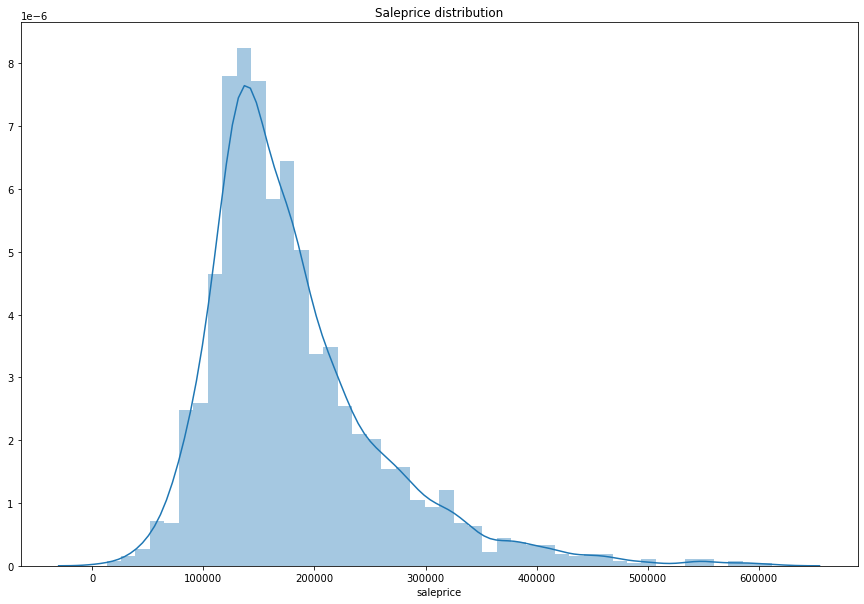

In [7]:
plt.figure(figsize=(15,10))
sns.distplot(y).set_title('Saleprice distribution');

#histogram of the same

In [8]:
q1, q3 = np.percentile(y,[25,75])
iqr = q3 - q1
lower = q1 - (1.5 * iqr) 
upper = q3 + (1.5 * iqr) 

In [9]:
lower

3531.25

In [10]:
upper

340281.25

I'm noticing a lot of right skew. Saleprice is not normally distributed. I initially tried to deal with this by removing outliers, but settled on cube root transforming Y which improved my model as seen at the bottom of the page.

In [11]:
df.shape

(2050, 352)

In [12]:
df['lot_area'].median()

9432.0

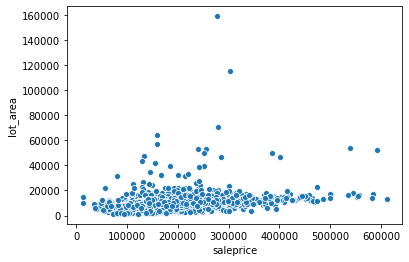

In [13]:
sns.scatterplot(x=df['saleprice'], y=df['lot_area'])

two very large outliers seen and to be removed

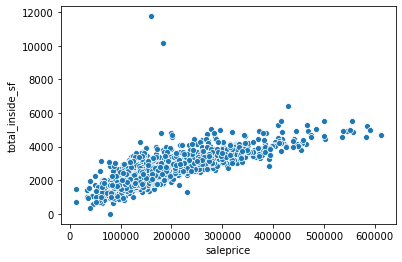

In [14]:
sns.scatterplot(x=df['saleprice'], y=df['total_inside_sf'])

In [15]:
df[df['total_inside_sf'] > 8000]

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,...,paved_drive_y,roof_matl_metal,roof_matl_roll,exterior_1st_precast,exterior_2nd_other,exterior_2nd_precast,mas_vnr_type_cblock,heating_gasa,kitchen_qual_2,sale_type_vwd
960,960,1499,908154235,60,RL,63887,Pave,IR3,Bnk,AllPub,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1884,1885,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# df.drop([960, 1884], axis=0, inplace=True)

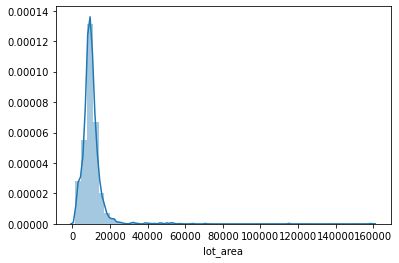

In [17]:
sns.distplot(df['lot_area'])

In [18]:
q1, q3 = np.percentile(df['lot_area'],[25,75])
iqr = q3 - q1
lower = q1 - (1.5 * iqr) 
upper = q3 + (1.5 * iqr) 

In [19]:
upper

17535.625

In [20]:
lower

1478.625

dropping lot area outliers

In [21]:
list = [i for i in df[df['lot_area'] > 17500].index]

In [22]:
df.drop(list, axis=0, inplace=True)

In [107]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.corr()['saleprice'].sort_values(ascending=False)

saleprice                      1.000000
total_inside_sf                0.830113
overall_qual                   0.815855
quality                        0.800237
lot_area * total_inside_sf     0.753598
year_built * gr_liv_area       0.742842
exter_qual                     0.728464
gr_liv_area                    0.721734
kitchen_qual                   0.707107
total_bsmt_sf                  0.676346
garage_area                    0.665024
garage_cars                    0.659567
1st_flr_sf                     0.659159
totrms_abvgrd * gr_liv_area    0.653976
total_bath_adj                 0.632718
total_bath                     0.612645
bsmt_qual_5                    0.605325
year_built                     0.600818
kitchen_qual_5                 0.565825
year_remod/add                 0.564839
foundation_pconc               0.560483
full_bath                      0.544689
fireplace_qu                   0.538674
mas_vnr_area                   0.521721
totrms_abvgrd                  0.513118


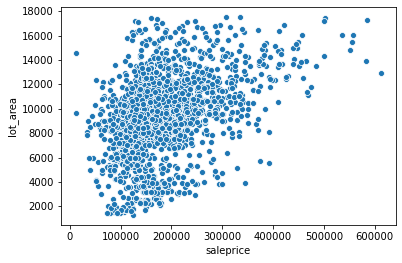

In [24]:
sns.scatterplot(x=df['saleprice'], y=df['lot_area'])
#new lot area to saleprice comparison with outliers removed

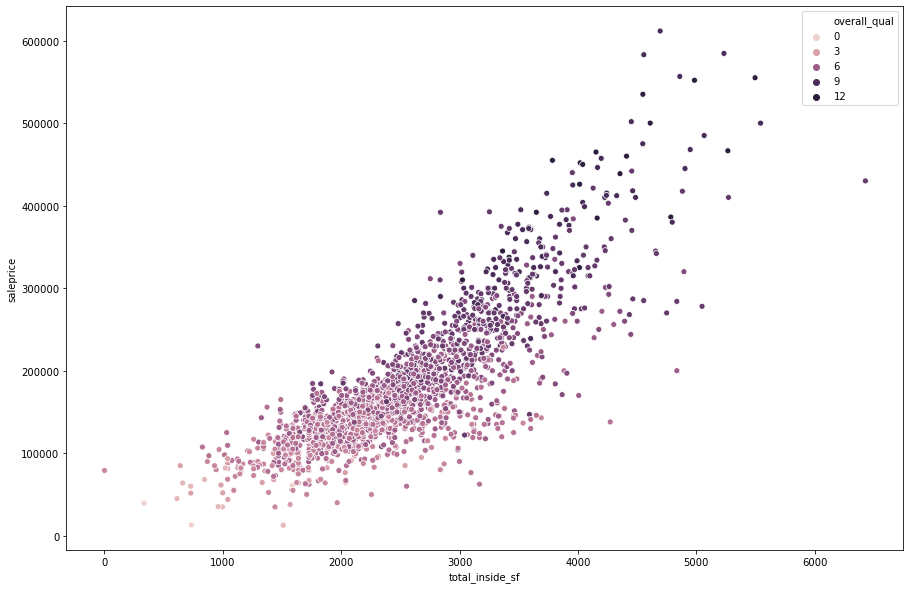

In [25]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df['total_inside_sf'], y=df['saleprice'], hue=df['overall_qual'])

# Baseline model

First linear regression model using my first features list

In [26]:
X = df[features]
y = df['saleprice']

lr = LinearRegression() #instantiate linear regression object
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#splitting data into training (80%) and testing (20%) sets
lr.fit(X_train, y_train) #fitting model to training data

train_score = lr.score(X_train, y_train) #train score r^2
test_score = lr.score(X_test, y_test) #test score r^2

predictions = lr.predict(X_test) #predictions for y generated from test data

print("train r2 score: ", train_score)
print("cross validation r2 score: ", cross_val_score(lr, X_train, y_train, cv=10).mean())
print("test r2 score: ", test_score)
print("------------------")
print(f'Y intercept:  {lr.intercept_}')
print(f'Coefficients:  {lr.coef_}')
print(f'RMSE:  {np.sqrt(mean_squared_error(y_test, predictions))}')

train r2 score:  0.916729585055356
cross validation r2 score:  0.9054884638496412
test r2 score:  0.898838440312152
------------------
Y intercept:  -21085.96556144851
Coefficients:  [ 4.45204677e+01  2.71976506e+00  2.67656390e+01  2.37606567e+03
  3.08488347e+01  1.94851739e+03 -5.20738172e+00  2.47328616e+04
 -5.51619782e+03 -3.30662600e+03 -4.54005745e+03  2.10357766e+04
  8.15150554e+02  5.30655991e+03  8.70797606e+03 -8.39524357e+03
  1.64355994e+04  2.49983393e+01  5.79320354e+03  1.21916413e+04
  4.15188908e+04 -7.66802823e+02  7.22960380e+03  8.09018587e+03
  5.40402040e+03  1.40442613e+04  3.31297565e+03  2.49231850e+03
 -9.38004779e+02  3.37208666e+02 -2.39348834e+03  6.86041936e+03
 -8.24406843e+03 -5.79637936e+03  1.69786884e+04 -1.37076258e+04
 -7.36801705e+03  1.64395553e+04  1.04860254e+05 -9.61594399e+03
 -1.07469235e+04 -1.17024989e+04 -9.96596704e+03 -9.33229974e+03
  6.22642816e+03 -1.12342817e+04  2.21594814e+04  1.48239949e+04
 -9.29533049e+03 -7.30026127e+02 -8.8

In [27]:
listy = [i for i in lr.coef_]

In [28]:
listy

[44.52046773647057,
 2.7197650562290754,
 26.76563901271524,
 2376.0656686329676,
 30.848834680959044,
 1948.5173896787378,
 -5.20738171943708,
 24732.86157471695,
 -5516.1978244527745,
 -3306.6260011332083,
 -4540.057451162842,
 21035.776631526303,
 815.1505535258193,
 5306.559913917747,
 8707.976059246159,
 -8395.243570574934,
 16435.599384924994,
 24.998339281142762,
 5793.203540526913,
 12191.641317346232,
 41518.89075665843,
 -766.802823272119,
 7229.603796525083,
 8090.185874743906,
 5404.020403779374,
 14044.261283759017,
 3312.975650437517,
 2492.3184960683975,
 -938.0047791955051,
 337.20866580171423,
 -2393.488339885824,
 6860.419361601205,
 -8244.06842706533,
 -5796.379355045066,
 16978.688439653186,
 -13707.625750166919,
 -7368.017046736946,
 16439.5552751639,
 104860.25353956423,
 -9615.943986754912,
 -10746.923546136812,
 -11702.498916457238,
 -9965.967040716436,
 -9332.299743984471,
 6226.428163243313,
 -11234.281703753455,
 22159.48137112022,
 14823.994868104808,
 -9295

Baseline residuls plotted

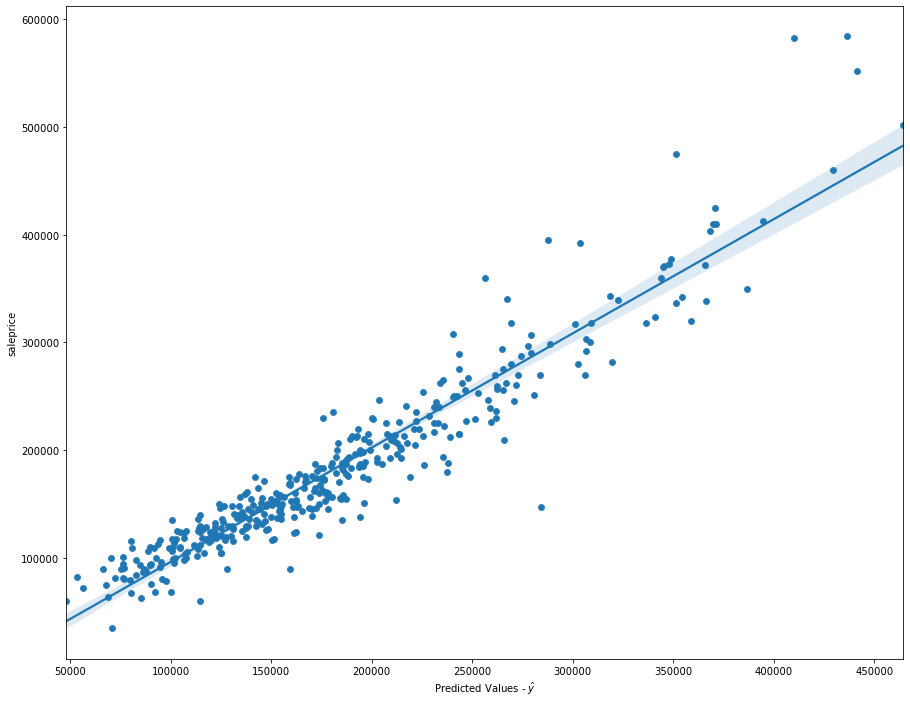

In [29]:
plt.figure(figsize=(15, 12))
sns.scatterplot(predictions, y_test)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
sns.regplot(predictions, y_test);
plt.show();

Having the individual quality features for each part of the house is better for the model than the combined quality.
Features list 3 will remove quality and condition and put more specific ones for each section



## New feature selections

In [30]:
features3 = ['gr_liv_area', 'lot_area', 'garage_area', 'total_bath_adj', 'total_bsmt_sf', 'bsmt_qual_1',
'bsmt_qual_2', 'bsmt_qual_3', 'bsmt_qual_4', 'bsmt_qual_5', 'foundation_cblock', 'foundation_pconc', 'foundation_slab', 
'foundation_stone', 'foundation_wood', 'mas_vnr_area', 'exter_qual_3', 'exter_qual_4', 'exter_qual_5', 'totrms_abvgrd', 
'fireplaces', 'bsmt1_alq', 'bsmt1_blq', 'bsmt1_glq', 'bsmt1_lwq', 'bsmt1_rec', 'bsmt1_unf', 'neighborhood_blueste', 
'neighborhood_brdale', 'neighborhood_brkside', 'neighborhood_clearcr',
'neighborhood_collgcr', 'neighborhood_crawfor', 'neighborhood_edwards', 'neighborhood_gilbert',
'neighborhood_greens', 'neighborhood_grnhill', 'neighborhood_idotrr', 'neighborhood_landmrk', 'neighborhood_meadowv',
'neighborhood_mitchel', 'neighborhood_names', 'neighborhood_npkvill', 'neighborhood_nwames',
'neighborhood_noridge', 'neighborhood_nridght', 'neighborhood_oldtown', 'neighborhood_swisu',
'neighborhood_sawyer', 'neighborhood_sawyerw', 'neighborhood_somerst', 'neighborhood_stonebr', 'neighborhood_timber',
'neighborhood_veenker', 'kitchen_qual_2', 'kitchen_qual_3', 'kitchen_qual_4', 'kitchen_qual_5',
'home_age', 'heating_gasw', 'heating_grav', 'heating_othw', 'heating_wall', 'heating_gasa', 'heating_qc_fa', 'heating_qc_gd', 'heating_qc_po', 'heating_qc_ta',
'garage_2types', 'garage_attchd', 'garage_basment', 'garage_builtin', 'garage_carport', 'garage_detchd',
'garage_fin', 'garage_rfn', 'garage_unf', 'exter_cond_2', 'exter_cond_3', 'exter_cond_4', 'exter_cond_5', 'bsmt_cond_1',
'bsmt_cond_2', 'bsmt_cond_3', 'bsmt_cond_4', 'bsmt_cond_5', 'garage_cond_1', 'garage_cond_2', 'garage_cond_3',
'garage_cond_4', 'garage_cond_5']

In [31]:
features4 = ['gr_liv_area', 'quality', 'lot_area', 'garage_area', 'total_bath_adj', 'total_bsmt_sf', 'garage_cars', 
'1st_flr_sf', 'foundation_cblock', 'foundation_pconc', 'foundation_slab', 'foundation_stone', 'foundation_wood', 
'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmt1_alq', 'bsmt1_blq', 'bsmt1_glq', 'bsmt1_lwq', 'bsmt1_rec', 
'bsmt1_unf', 'neighborhood_blueste', 'neighborhood_brdale', 'neighborhood_brkside', 'neighborhood_clearcr',
'neighborhood_collgcr', 'neighborhood_crawfor', 'neighborhood_edwards', 'neighborhood_gilbert',
'neighborhood_greens', 'neighborhood_grnhill', 'neighborhood_idotrr', 'neighborhood_landmrk', 'neighborhood_meadowv',
'neighborhood_mitchel', 'neighborhood_names', 'neighborhood_npkvill', 'neighborhood_nwames',
'neighborhood_noridge', 'neighborhood_nridght', 'neighborhood_oldtown', 'neighborhood_swisu',
'neighborhood_sawyer', 'neighborhood_sawyerw', 'neighborhood_somerst', 'neighborhood_stonebr', 'neighborhood_timber',
'neighborhood_veenker', 'kitchen_qual_2', 'kitchen_qual_3', 'kitchen_qual_4', 'kitchen_qual_5',
'home_age', 'heating_gasw', 'heating_grav', 'heating_othw', 'heating_wall', 'heating_gasa', 'heating_qc_fa', 'heating_qc_gd', 
'heating_qc_po', 'heating_qc_ta', 'garage_2types', 'garage_attchd', 'garage_basment', 'garage_builtin', 'garage_carport', 
'garage_detchd', 'garage_fin', 'garage_rfn', 'garage_unf']

In [32]:
features5 = ['gr_liv_area', 'garage_area', 'garage_cars', 'total_bath_adj', 'total_bsmt_sf', '1st_flr_sf', 
'bsmt_cond_1', 'bsmt_cond_2', 'bsmt_cond_3', 'bsmt_cond_4', 'bsmt_qual_5', 'year_built', 'kitchen_qual_2', 
'kitchen_qual_3', 'kitchen_qual_4', 'kitchen_qual_5']          

Here I have spent a lot of time selecting and engineering features for use in my models.

In [33]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.corr()['saleprice'].sort_values(ascending=False)[0:10]

saleprice          1.000000
total_inside_sf    0.830113
overall_qual       0.815855
quality            0.800237
exter_qual         0.728464
gr_liv_area        0.721734
kitchen_qual       0.707107
total_bsmt_sf      0.676346
garage_area        0.665024
garage_cars        0.659567
Name: saleprice, dtype: float64

In [34]:
features6 = ['total_bsmt_sf', 'gr_liv_area',  'kitchen_qual_2', 'kitchen_qual_3', 'kitchen_qual_4','kitchen_qual_5', 
'exter_qual_3', 'exter_qual_4', 'exter_qual_5', 'garage_area', 'cbrt_home_age', 
'fireplaces', 'neighborhood_blueste', 'neighborhood_brdale', 'neighborhood_brkside', 
'neighborhood_clearcr', 'neighborhood_collgcr', 'neighborhood_crawfor', 'neighborhood_edwards', 'neighborhood_gilbert',
'neighborhood_greens', 'neighborhood_grnhill', 'neighborhood_idotrr', 'neighborhood_landmrk', 'neighborhood_meadowv',
'neighborhood_mitchel', 'neighborhood_names', 'neighborhood_npkvill', 'neighborhood_nwames',
'neighborhood_noridge', 'neighborhood_nridght', 'neighborhood_oldtown', 'neighborhood_swisu',
'neighborhood_sawyer', 'neighborhood_sawyerw', 'neighborhood_somerst', 'neighborhood_stonebr', 'neighborhood_timber',
'neighborhood_veenker',  'bsmt_qual_1', 'bsmt_qual_2', 'bsmt_qual_3', 'bsmt_qual_4', 'bsmt_qual_5',
'foundation_cblock', 'foundation_pconc', 'foundation_slab', 'bsmt1_alq', 'bsmt1_blq', 'bsmt1_glq', 'bsmt1_lwq',
'bsmt1_rec', 'bsmt1_unf', 'garage_2types', 'garage_attchd', 'garage_basment', 'garage_builtin', 'garage_carport',
'garage_detchd', 'garage_fin', 'garage_rfn','garage_unf', 'foundation_stone', 'foundation_wood']

In [35]:
df[['gr_liv_area', 'totrms_abvgrd']].corr()

,gr_liv_area,totrms_abvgrd
gr_liv_area,1.000000,0.815283
totrms_abvgrd,0.815283,1.000000


Testing for multicolinearity, I see that these first two features are strongly linearly related so I will choose the ones with most explanatory power and leave the others out.

In [36]:
df[['gr_liv_area', 'total_bath_adj']].corr()

,gr_liv_area,total_bath_adj
gr_liv_area,1.000000,0.585806
total_bath_adj,0.585806,1.000000


In [37]:
df[['total_bsmt_sf', 'gr_liv_area']].corr()

,total_bsmt_sf,gr_liv_area
total_bsmt_sf,1.000000,0.419493
gr_liv_area,0.419493,1.000000


## Feature engineering to explore interaction terms and other things

In [38]:
df['totrms_abvgrd * gr_liv_area'] = df['gr_liv_area'] * df['totrms_abvgrd']
test_df['totrms_abvgrd * gr_liv_area'] = test_df['gr_liv_area'] * test_df['totrms_abvgrd']
#interaction term of total rooms above ground and above ground living sq ft

df['year_built * gr_liv_area'] = df['gr_liv_area'] * df['year_built']
test_df['year_built * gr_liv_area'] = test_df['gr_liv_area'] * test_df['year_built']
#interaction term of year built and above ground living sq ft

df['lot_area * total_inside_sf'] = df['total_inside_sf'] * df['lot_area']
test_df['lot_area * total_inside_sf'] = test_df['total_inside_sf'] * test_df['lot_area']
#interaction term of lot area and total inside sq ft

df['misc_val * total_outside_sf'] = df['total_outside_sf'] * df['misc_val']
test_df['misc_val * total_outside_sf'] = test_df['total_outside_sf'] * test_df['misc_val']
#interaction term of misc value and total outside sf

df['misc_val * condition'] = df['condition'] * df['misc_val']
test_df['misc_val * condition'] = test_df['condition'] * test_df['misc_val']
#interaction term of misc value and condition

df['age_stuff'] = np.log1p(df['remod_age'] * df['home_age'])
test_df['age_stuff'] = np.log1p(test_df['remod_age'] * test_df['home_age'])
#interaction term of log of years since remodel and actual home age

df['log_home_age'] = np.log1p(df['home_age'])
test_df['log_home_age'] = np.log1p(test_df['home_age'])
#log of home age

df['cbrt_home_age'] = np.cbrt(df['home_age'])
test_df['cbrt_home_age'] = np.cbrt(test_df['home_age'])
#cube root of home age

df['sqrt_home_age'] = np.sqrt(df['home_age'])
test_df['sqrt_home_age'] = np.sqrt(test_df['home_age'])
#square root of home age

df['home_age * remod_age'] = df['remod_age'] * df['home_age']
test_df['home_age * remod_age'] = test_df['remod_age'] * test_df['home_age']
#interaction term of home age and remod age

In [39]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.corr()['saleprice'].sort_values(ascending=False)[0:10]

saleprice                     1.000000
total_inside_sf               0.830113
overall_qual                  0.815855
quality                       0.800237
lot_area * total_inside_sf    0.753598
year_built * gr_liv_area      0.742842
exter_qual                    0.728464
gr_liv_area                   0.721734
kitchen_qual                  0.707107
total_bsmt_sf                 0.676346
Name: saleprice, dtype: float64

In [40]:
df['condition'].value_counts()

3.000000    1576
3.333333     207
2.666667      78
3.666667      33
2.333333      18
2.500000      16
3.500000      15
2.000000      14
4.000000       3
4.333333       1
1.333333       1
1.500000       1
1.000000       1
Name: condition, dtype: int64

In [41]:
df[['fireplaces', 'gr_liv_area']].corr()

,fireplaces,gr_liv_area
fireplaces,1.000000,0.441627
gr_liv_area,0.441627,1.000000


## Exploring square feet, home age, and remodeling features

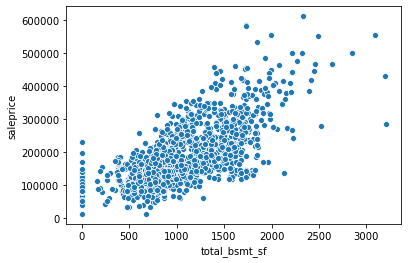

In [42]:
sns.scatterplot(df['total_bsmt_sf'], df['saleprice'])

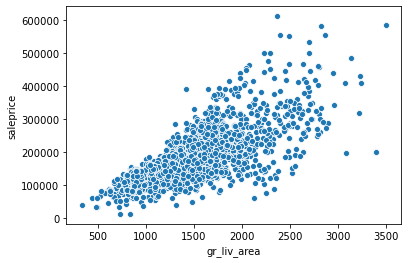

In [43]:
sns.scatterplot(df['gr_liv_area'], df['saleprice'])

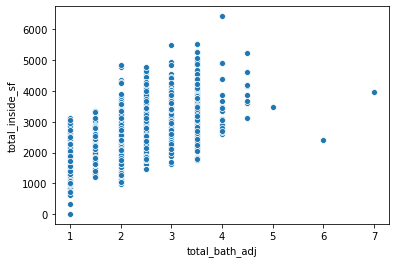

In [44]:
sns.scatterplot(df['total_bath_adj'], df['total_inside_sf'])

In [45]:
# list = [i for i in df[df['total_bath_adj'] >= 5].index]

In [46]:
# df.drop(list, axis=0, inplace=True)

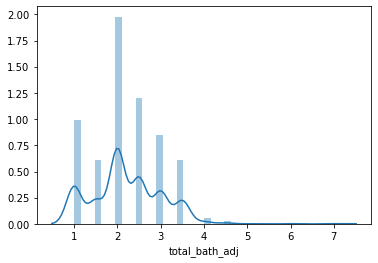

In [47]:
sns.distplot(df['total_bath_adj'])

Text(0.5, 1.0, 'sale price by home age')

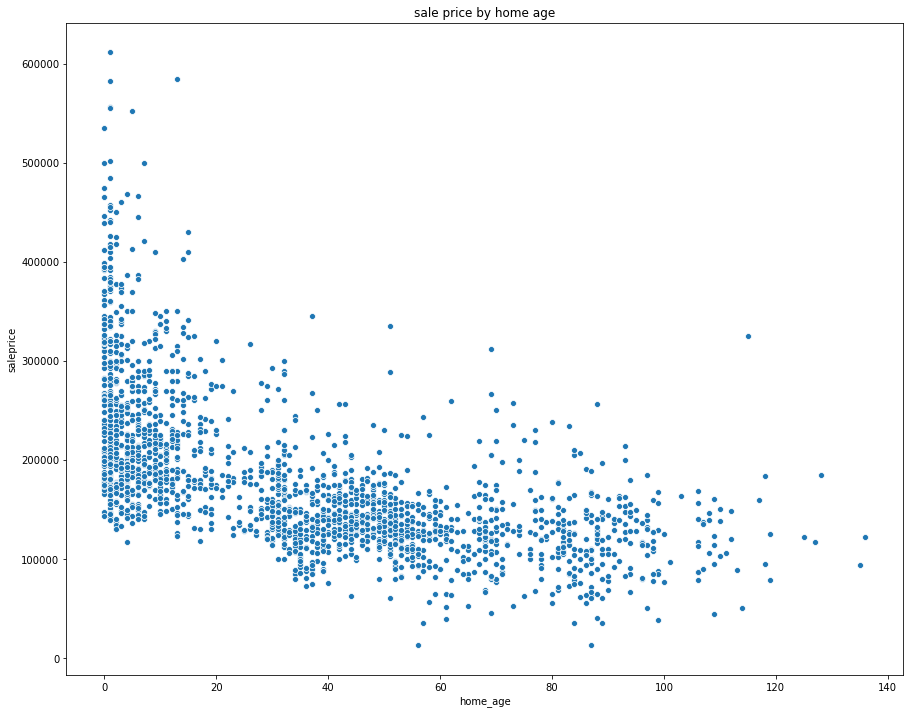

In [48]:
plt.figure(figsize=(15, 12))
sns.scatterplot(df['home_age'], df['saleprice']).set_title('sale price by home age')

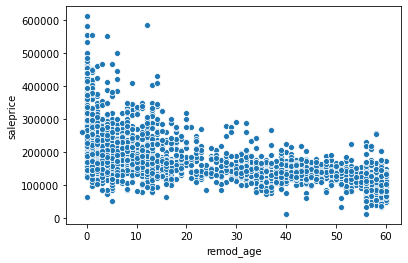

In [49]:
sns.scatterplot(df['remod_age'], df['saleprice'])

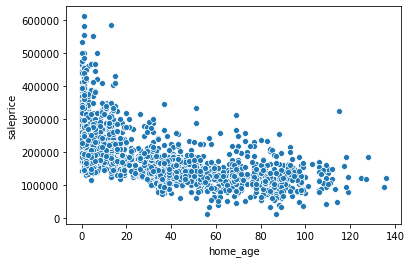

In [50]:
sns.scatterplot(x=df['home_age'], y = df['saleprice'])

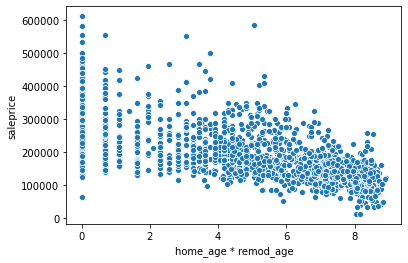

In [51]:
sns.scatterplot(np.log1p(df['home_age * remod_age']), df['saleprice'])

Text(0.5, 1.0, 'cube root of sales by home age')

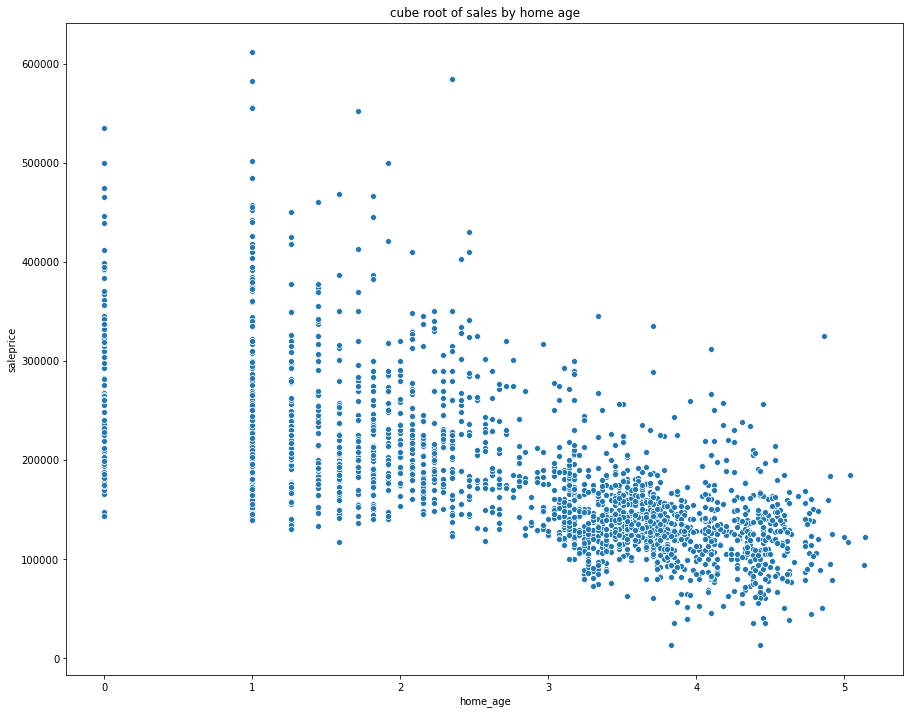

In [52]:
plt.figure(figsize=(15, 12))
sns.scatterplot(x=np.cbrt(df['home_age']), y = df['saleprice']).set_title('cube root of sales by home age')

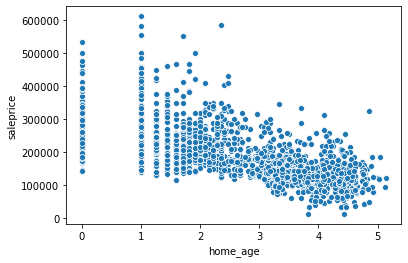

In [53]:
sns.scatterplot(x=np.cbrt(df['home_age']), y = df['saleprice'])

Seeing that home age and remodeling age are strong predictors of home price, but not entirely linearly correlated, I have created log values, sqrt and cbrt transformed features to make them more linear. I have chosen the cube root home age feature moving forward for its higher predictive power.

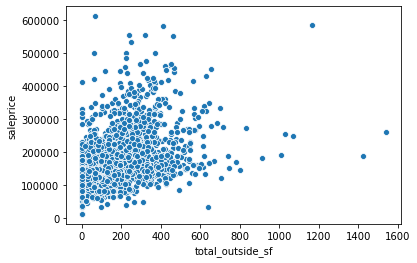

In [54]:
sns.scatterplot(df['total_outside_sf'], df['saleprice'])

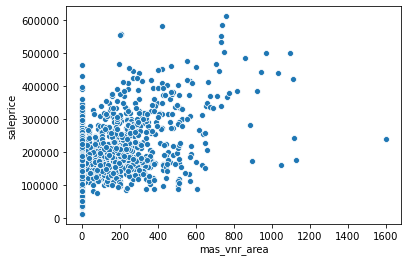

In [55]:
sns.scatterplot(df['mas_vnr_area'], df['saleprice'])

I'm going to break my features down into several sections to test for multicolinearity.

In [56]:
area = ['gr_liv_area', 'lot_area', 'garage_area', 'total_bath_adj', 'total_bsmt_sf', 'garage_cars', '1st_flr_sf', 'mas_vnr_area', 'fireplaces']

In [57]:
neighborhoods = ['neighborhood_blueste', 'neighborhood_brdale', 'neighborhood_brkside', 'neighborhood_clearcr',
'neighborhood_collgcr', 'neighborhood_crawfor', 'neighborhood_edwards', 'neighborhood_gilbert',
'neighborhood_greens', 'neighborhood_grnhill', 'neighborhood_idotrr', 'neighborhood_landmrk', 'neighborhood_meadowv',
'neighborhood_mitchel', 'neighborhood_names', 'neighborhood_npkvill', 'neighborhood_nwames',
'neighborhood_noridge', 'neighborhood_nridght', 'neighborhood_oldtown', 'neighborhood_swisu',
'neighborhood_sawyer', 'neighborhood_sawyerw', 'neighborhood_somerst', 'neighborhood_stonebr', 'neighborhood_timber']
#list of neighborhood related features

In [58]:
na = neighborhoods + area

In [59]:
quality = ['bsmt_qual_1', 'quality', 'condition',
'bsmt_qual_2', 'bsmt_qual_3', 'bsmt_qual_4', 'bsmt_qual_5', 'exter_qual_3', 'exter_qual_4', 'exter_qual_5', 'totrms_abvgrd', 
'fireplaces', 'bsmt1_alq', 'bsmt1_blq', 'bsmt1_glq', 'bsmt1_lwq', 'bsmt1_rec', 'bsmt1_unf', 'kitchen_qual_2', 'kitchen_qual_3', 'kitchen_qual_4', 'kitchen_qual_5',
'home_age', 'exter_cond_2', 'exter_cond_3', 'exter_cond_4', 'exter_cond_5', 'bsmt_cond_1',
'bsmt_cond_2', 'bsmt_cond_3', 'bsmt_cond_4', 'bsmt_cond_5', 'garage_cond_1', 'garage_cond_2', 'garage_cond_3',
'garage_cond_4', 'garage_cond_5']
#list of quality related features

In [60]:
other = ['foundation_cblock', 'foundation_pconc', 'foundation_slab', 
'foundation_stone', 'foundation_wood', 'mas_vnr_area', 'heating_gasw', 'heating_grav', 'heating_othw', 'heating_wall', 'heating_gasa', 'heating_qc_fa', 'heating_qc_gd', 'heating_qc_po', 'heating_qc_ta',
'garage_2types', 'garage_attchd', 'garage_basment', 'garage_builtin', 'garage_carport', 'garage_detchd',
'garage_fin', 'garage_rfn', 'garage_unf']
#other features

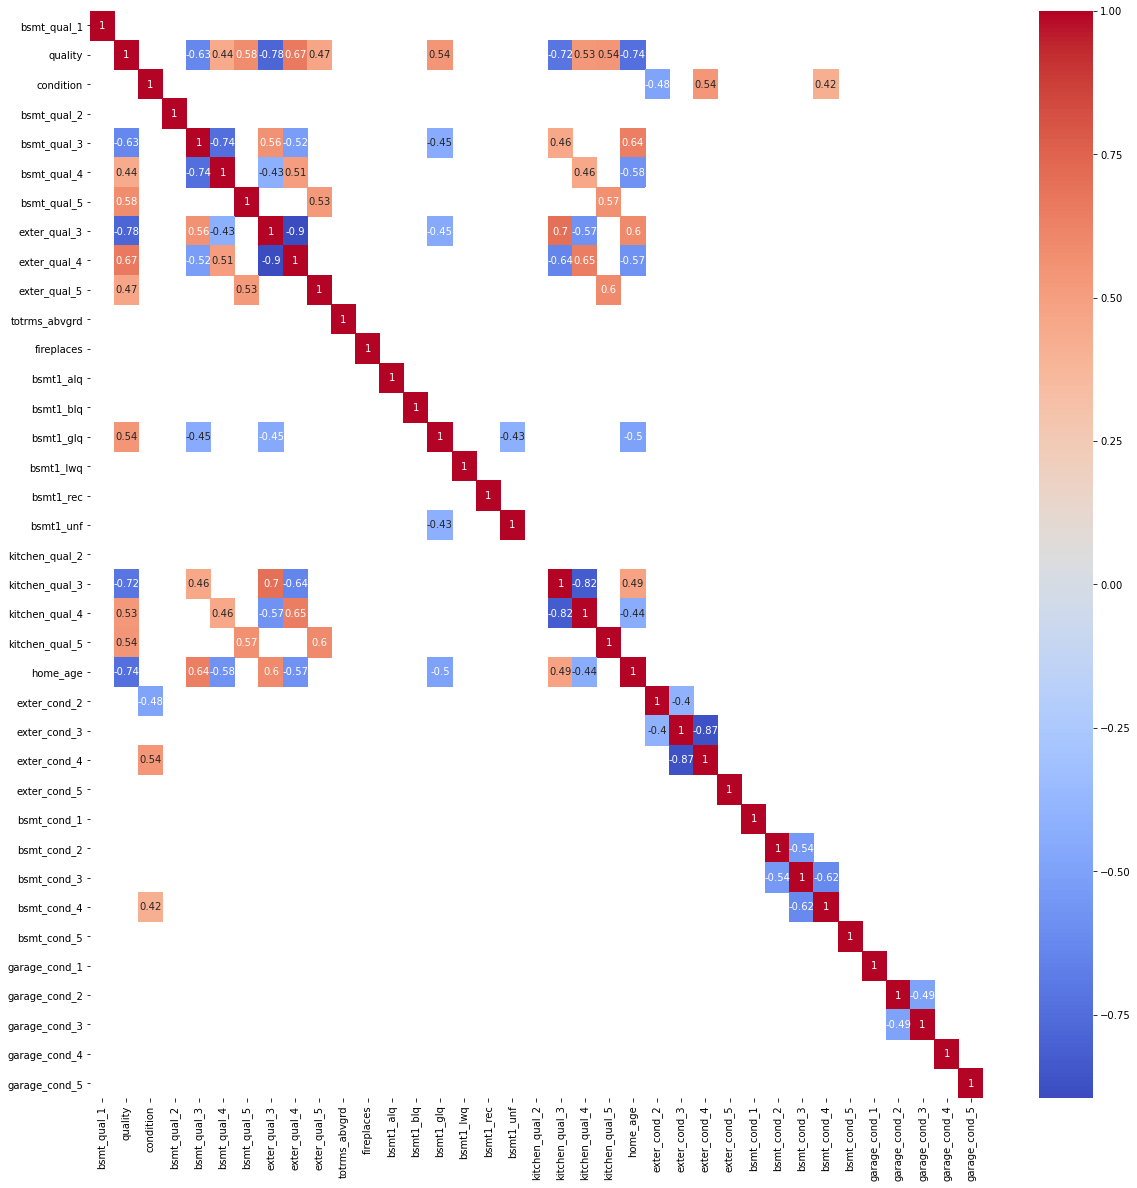

In [61]:
df_corr = df[quality].corr()
plt.figure(figsize=(20,20))
sns.heatmap(df_corr[np.abs(df_corr)>.4], annot=True, cmap='coolwarm');

Quality ones are all colinear

In [62]:
df['bsmt_cond_4'].max()

1

Multicolinearity: 
Garage area chosen over garage cars because both are strongly related but the first has more price explanatory power. 
basement sf and 1st floor sf
                    

In [63]:
[i for i in df.columns if "exter_qual" in i]

['exter_qual', 'exter_qual_3', 'exter_qual_4', 'exter_qual_5']

In [64]:
df[['home_age', 'remod_age', 'saleprice']].corr()

,home_age,remod_age,saleprice
home_age,1.000000,0.641189,-0.600221
remod_age,0.641189,1.000000,-0.565391
saleprice,-0.600221,-0.565391,1.000000


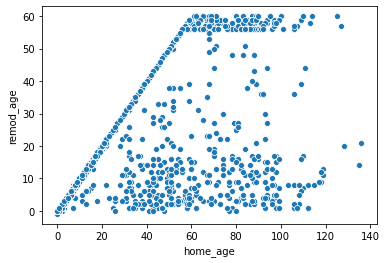

In [65]:
sns.scatterplot(x=df['home_age'], y = df['remod_age'])

Using both home age and remodeling age would not be wise.

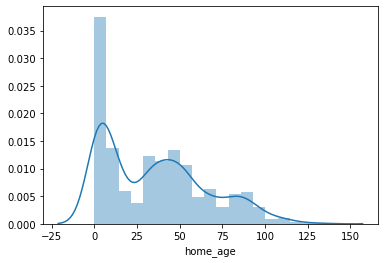

In [66]:
sns.distplot(df['home_age'])

## Second model

Second model with some improvement over the last!

In [67]:
X = df[features3]
y = df['saleprice']

lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

predictions = lr.predict(X_test)

print("train r2 score: ", train_score)
print("cross validation r2 score: ", cross_val_score(lr, X_train, y_train, cv=10).mean())
print("test r2 score: ", test_score)
print("------------------")
print(f'Y intercept:  {lr.intercept_}')
print(f'Coefficients:  {lr.coef_}')

train r2 score:  0.9160009745180889
cross validation r2 score:  0.9033411079643523
test r2 score:  0.8970295102762349
------------------
Y intercept:  -28410.598771468358
Coefficients:  [ 4.35135063e+01  2.70950334e+00  3.21831256e+01  3.14700122e+03
  2.64280798e+01  1.76528130e+04 -8.05049693e+03 -4.83392270e+03
 -5.57520960e+03  1.96006340e+04  2.07537812e+02  5.42211490e+03
  7.42079632e+03 -7.11021837e+03  1.81356123e+04  2.47351682e+01
  7.28920339e+03  1.41803363e+04  4.39530710e+04 -7.21131825e+02
  6.92201636e+03  6.15181343e+03  2.94302120e+03  1.19491877e+04
  9.49424184e+02 -6.14170934e+02 -2.58545785e+03  5.02626651e+02
 -3.51162744e+03  5.15096342e+03 -1.00129370e+04 -6.21205746e+03
  1.61981735e+04 -1.48488774e+04 -7.10894853e+03  1.48158310e+04
  1.02759119e+05 -1.22269428e+04 -1.02388816e+04 -1.30947549e+04
 -1.04411920e+04 -1.09194256e+04  5.52101796e+03 -1.24323842e+04
  2.13459156e+04  1.46999110e+04 -1.02407701e+04 -3.01120316e+03
 -9.57297994e+03 -9.43679592e+03  

Lasso CV with features3

In [68]:
l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

lasso_cv.fit(X_train, y_train);
y_preds = lasso_cv.predict(X_test)
print(lasso_cv.alpha_)

print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))
# print(np.sqrt(mean_squared_log_error(y_test, y_preds)))

1.0
0.9159949364187252
0.8970868820563864


In [69]:
lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [70]:
# Create dictionary of hyperparameters.
# The keys MUST match the names of the arguments!
# lr_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_params = {'copy_X':[True, False], 'fit_intercept':[True,False], 'normalize':[True,False]}


# # find optimal alpha with grid search
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
grid_lr = GridSearchCV(estimator=lr, param_grid=lr_params, verbose=1, n_jobs=-1)
grid_result = grid_lr.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score:  0.9032766563840798
Best Params:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


In [71]:
[i for i in df.columns if 'pool' in i]

['pool_area', 'pool_ex', 'pool_fa', 'pool_gd', 'pool_ta']

Features6 shows the best improvement so far in explanatory power. Models using these features don't appear overly over or underfit.

In [72]:
X = df[features6]
y = df['saleprice']

l_alphas = np.logspace(-3, 0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

lasso_cv.fit(X_train, y_train);

lasso_cv_preds = lasso_cv.predict(X_test)
print(lasso_cv.alpha_)

print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))


1.0
0.905651098949242
0.8876882898754297


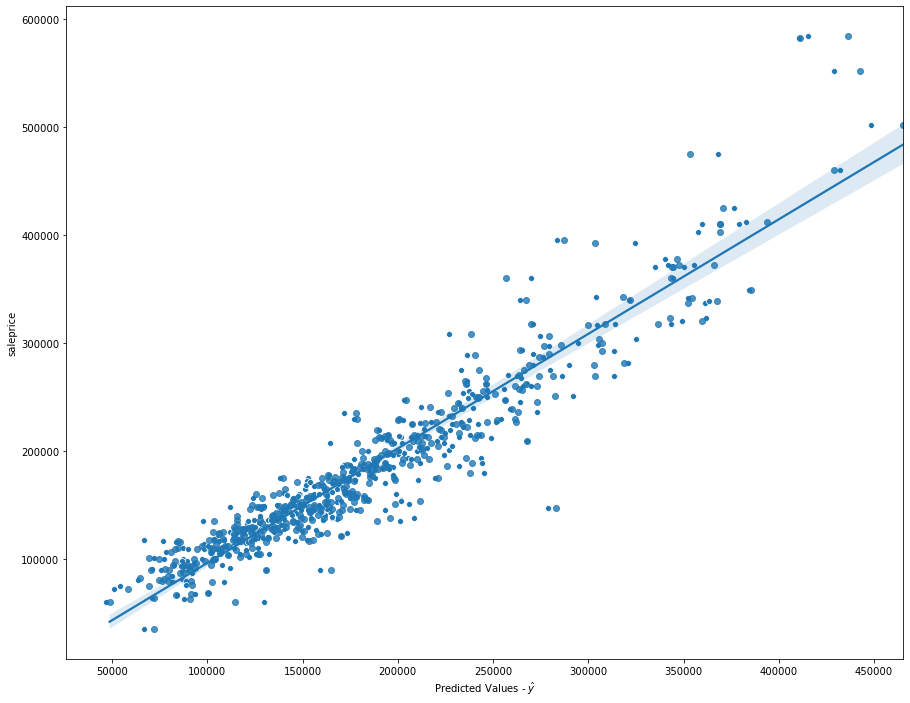

In [73]:
plt.figure(figsize=(15, 12))
sns.scatterplot(lasso_cv_preds, y_test)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
sns.regplot(predictions, y_test);
plt.show();

In [74]:
# scaled_features = X.copy()

# features = scaled_features[num_features]


# scaler = RobustScaler().fit(features.values)
# features = scaler.transform(features.values)
# scaled_features[num_features] = features

# X = scaled_features[features6]
# y = df['saleprice']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I tried MinMaxScaler, 
minmax_scale, 
MaxAbsScaler, StandardScaler,
RobustScaler, Normalizer, QuantileTransformer, and PowerTransformer without much positive affect.

In [75]:
X = df[features6]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

lasso_cv.fit(X_train, y_train);
y_train_preds = lasso_cv.predict(X_train)
y_test_preds = lasso_cv.predict(X_test)
print(lasso_cv.alpha_)

print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))
print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test, y_test_preds))}')

1.0
0.905651098949242
0.8876882898754297
train RMSE:  23225.495574227145
test RMSE:  28596.808117713244


### Cube root, square root, and log transformations were performed on y to deal with right skew. 

In [76]:
X = df[features6]
y = np.cbrt(df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

lasso_cv.fit(X_train, y_train);

y_train_preds = lasso_cv.predict(X_train)**3
y_test_preds = lasso_cv.predict(X_test)**3
print(lasso_cv.alpha_)

print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

best_lasso = lasso_cv.predict(test_df[features6])**3
print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train**3, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test**3, y_test_preds))}')

0.001
0.904253790898417
0.9006489804150428
train RMSE:  21453.028239866733
test RMSE:  26303.607396341235


In [77]:
X = df[features6]
y = np.sqrt(df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
lasso_cv.fit(X_train, y_train);
y_train_preds = lasso_cv.predict(X_train)**2
y_test_preds = lasso_cv.predict(X_test)**2

print(lasso_cv.alpha_)
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))
print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train**2, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test**2, y_test_preds))}')

sqrt_lasso = (lasso_cv.predict(test_df[features6]))**2

0.004037017258596553
0.9099896742002243
0.9023153617398577
train RMSE:  21699.042377806865
test RMSE:  26812.94858006644


In [78]:
best_lasso[:10]

array([117119.54474538, 203216.69726894, 205253.87038381, 108394.83052103,
       175066.48187568,  94232.61341962, 106133.14662127, 152056.24397304,
       192279.48307705, 162169.59937015])

In [79]:
print("Coefficients:  ", [f"{X_train.columns[i]}: {lasso_cv.coef_[i]}" for i in range(len(X.columns))])

Coefficients:   ['total_bsmt_sf: 0.029694941034786038', 'gr_liv_area: 0.05936300937409697', 'kitchen_qual_2: 0.0', 'kitchen_qual_3: 20.292901659178824', 'kitchen_qual_4: 30.52537992654942', 'kitchen_qual_5: 57.92584733879898', 'exter_qual_3: 27.5234255087385', 'exter_qual_4: 34.11204412230386', 'exter_qual_5: 56.854743798617456', 'garage_area: 0.045796052312188085', 'cbrt_home_age: -7.782677607728625', 'fireplaces: 9.728168496176838', 'neighborhood_blueste: -5.680367527164861', 'neighborhood_brdale: -6.380390198722976', 'neighborhood_brkside: 16.867290308223513', 'neighborhood_clearcr: 8.706832399367341', 'neighborhood_collgcr: 11.818327045817957', 'neighborhood_crawfor: 40.496086942491175', 'neighborhood_edwards: -1.3972978982847106', 'neighborhood_gilbert: 11.756957245625541', 'neighborhood_greens: 11.608445269423447', 'neighborhood_grnhill: 128.2675569352624', 'neighborhood_idotrr: -9.656544183205778', 'neighborhood_landmrk: -0.20649544304459652', 'neighborhood_meadowv: -29.11316320

In [80]:
X = df[features6]
y = np.cbrt(df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

y_train_preds = lr.predict(X_train)**3
y_test_preds = lr.predict(X_test)**3

print("train r2 score: ", train_score)
print("cross validation r2 score: ", cross_val_score(lr, X_train, y_train, cv=10).mean())
print("test r2 score: ", test_score)
print("------------------")
print(f'Y intercept:  {lr.intercept_}')
print(f'Coefficients:  {lr.coef_}')
print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train**3, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test**3, y_test_preds))}')

train r2 score:  0.904585303097975
cross validation r2 score:  -1445675510.3681884
test r2 score:  0.9000172044198026
------------------
Y intercept:  33.72690631062268
Coefficients:  [ 2.48184718e-03  5.36603179e-03  6.89965446e-12  2.12270196e+00
  3.07550713e+00  5.31798765e+00  2.97728995e+00  3.54521221e+00
  5.24133712e+00  3.85285458e-03 -6.99795355e-01  8.38761839e-01
 -3.87340291e-01 -7.51066196e-01  1.72542038e+00  1.12202749e+00
  1.25884053e+00  3.94694442e+00  6.05927496e-02  1.29011137e+00
  1.59933038e+00  1.18783175e+01 -9.66504023e-01 -4.36280392e-01
 -2.77758576e+00  1.13729477e+00  9.25801458e-01 -2.07202319e-02
  1.04125501e+00  2.77630078e+00  2.39642838e+00  1.16354729e-01
  1.45858213e+00  1.14823616e+00  9.89239489e-01  1.92805083e+00
  4.13481567e+00  1.95886821e+00  3.34729335e+00  9.16032784e-01
 -1.44762798e-02  1.03928376e+00  1.18578703e+00  2.70128820e+00
  5.22930753e-01  9.22099891e-01  5.01100199e-01  1.61844159e+00
  1.07414943e+00  1.87894556e+00  6.

In [81]:
predictions[0:10]

array([269844.76650066, 116435.14993184, 115438.56375354, 354652.06891789,
       168987.52951659,  87363.8698005 , 149891.41694165, 159511.13380346,
       190118.81228643,  84651.64576076])

## Exploring how transformations affect skew

Text(0.5, 1.0, 'distribution of sale prices')

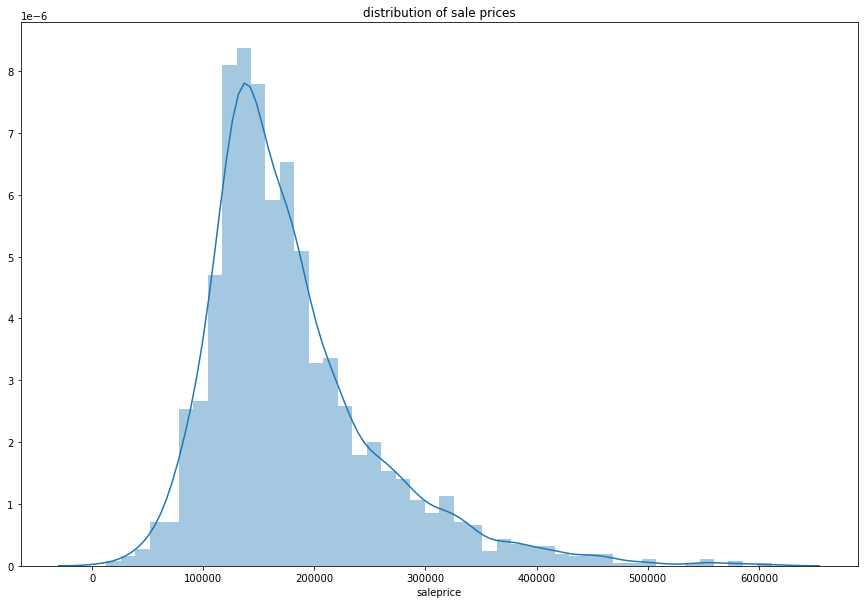

In [82]:
plt.figure(figsize=(15,10))
sns.distplot(df['saleprice']).set_title('distribution of sale prices')

Text(0.5, 1.0, 'cube root of saleprice distribution')

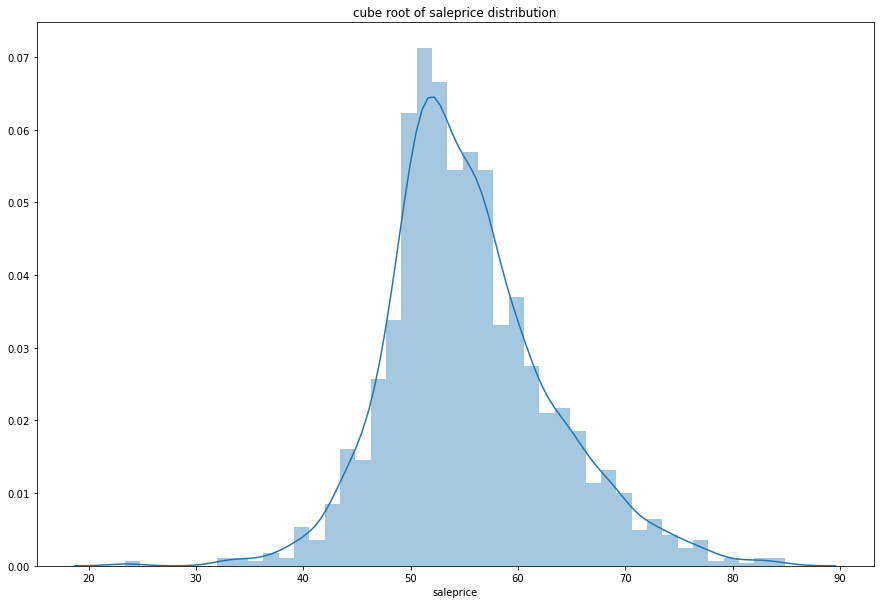

In [83]:
plt.figure(figsize=(15,10))
sns.distplot(y).set_title('cube root of saleprice distribution')

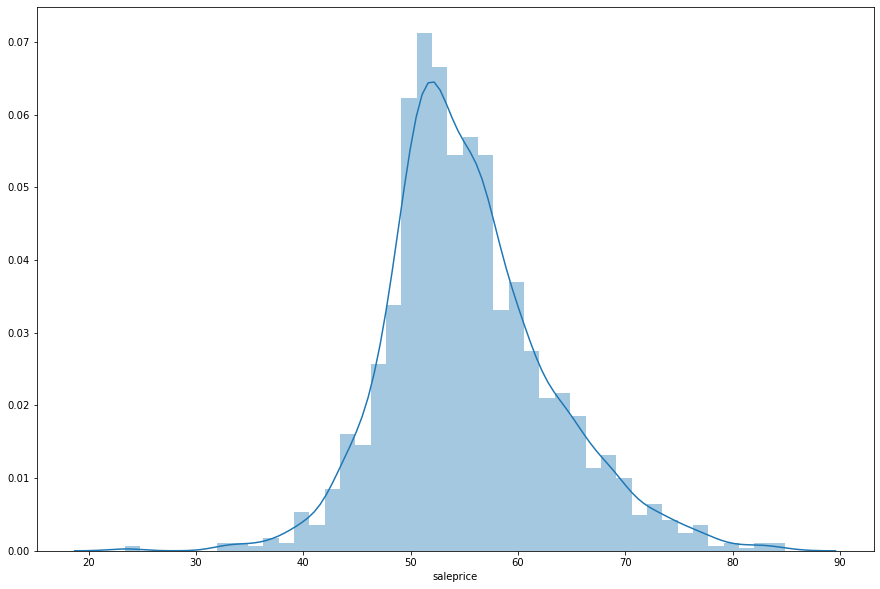

In [84]:
plt.figure(figsize=(15,10))
sns.distplot(np.cbrt(df['saleprice']))

In [85]:
lasso_preds = lasso_cv.predict(test_df[features6])

In [86]:
kaggle = pd.DataFrame()
kaggle['Id'] = test_df['id']
kaggle['SalePrice'] = lasso_preds
kaggle.to_csv('to_submit.csv', index=False)

## Final model

In [87]:
X = df[features6]
y = np.cbrt(df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

r_alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=10)

ridge_cv = ridge_cv.fit(X_train, y_train)

y_train_preds = (ridge_cv.predict(X_train))**3
y_test_preds = (ridge_cv.predict(X_test))**3

best_ridge = ridge_cv.predict(test_df[features6])**3

print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train**3, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test**3, y_test_preds))}')

train RMSE:  21506.72697499208
test RMSE:  26343.081820564108


In [88]:
print(ridge_cv.score(X_train, y_train))
print(ridge_cv.score(X_test, y_test))

0.9039556840673911
0.9007337750825836


In [89]:
list = [i for i in ridge_cv.coef_]

In [90]:
coefficient_list = [i for i in zip(features6, list)]

In [91]:
coefficient_list

[('total_bsmt_sf', 0.0025396543924199244),
 ('gr_liv_area', 0.005415320494942366),
 ('kitchen_qual_2', 0.0),
 ('kitchen_qual_3', 1.913059346660316),
 ('kitchen_qual_4', 2.85346230997127),
 ('kitchen_qual_5', 5.051014441222365),
 ('exter_qual_3', 2.4924288856106487),
 ('exter_qual_4', 3.045868003081249),
 ('exter_qual_5', 4.679975561205504),
 ('garage_area', 0.003846372412330918),
 ('cbrt_home_age', -0.69555012121902),
 ('fireplaces', 0.8393770508561884),
 ('neighborhood_blueste', -0.9863036610075848),
 ('neighborhood_brdale', -1.41911705561398),
 ('neighborhood_brkside', 0.8502572519214858),
 ('neighborhood_clearcr', 0.23206882033396561),
 ('neighborhood_collgcr', 0.4621971912868967),
 ('neighborhood_crawfor', 3.040238320430524),
 ('neighborhood_edwards', -0.7569240513301759),
 ('neighborhood_gilbert', 0.5110171742755005),
 ('neighborhood_greens', 0.6110959158548485),
 ('neighborhood_grnhill', 7.1825607016477795),
 ('neighborhood_idotrr', -1.8460763388029773),
 ('neighborhood_landmrk',

In [92]:
ridge_cv.alpha_

1.0

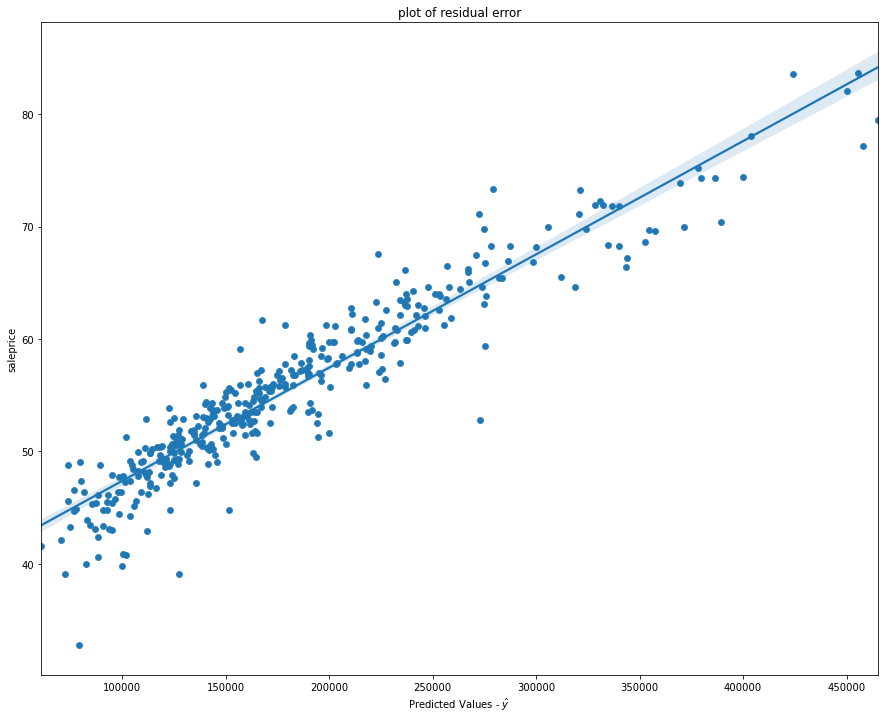

In [93]:
plt.figure(figsize=(15, 12))
sns.scatterplot(y_test_preds, y_test).set_title('plot of residual error')
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
sns.regplot(y_test_preds, y_test);
plt.show();

## Trying a few last models

In [94]:
lr_params = {
             'fit_intercept':[True,False], 
             'normalize':[True,False],
             'cv':[5,10,15]}

grid = GridSearchCV(estimator=ridge_cv, param_grid=lr_params, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


Best Score:  0.8938681978408722
Best Params:  {'cv': 10, 'fit_intercept': True, 'normalize': False}


In [95]:
ridge_cv.get_params().keys()

dict_keys(['alphas', 'cv', 'fit_intercept', 'gcv_mode', 'normalize', 'scoring', 'store_cv_values'])

In [96]:
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

2.38725125942001
0.8965204704457453
2.548619467522588
0.8999611042154806


In [97]:
elastic_preds = model_enet.predict(test_df[features6])

## Saving final model

In [98]:
kaggle = pd.DataFrame()
kaggle['Id'] = test_df['id']
kaggle['SalePrice'] = best_ridge
kaggle.to_csv('test_predictions.csv', index=False)

Trying something else:

In [99]:
X = df[features6]
y = np.log(df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

r_alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=10)

ridge_cv = ridge_cv.fit(X_train, y_train)

y_train_preds = np.exp(ridge_cv.predict(X_train))
y_test_preds = np.exp(ridge_cv.predict(X_test))

best_ridge = np.exp(ridge_cv.predict(test_df[features6]))

print(f'train RMSE:  {np.sqrt(mean_squared_error(np.exp(y_train), y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(np.exp(y_test), y_test_preds))}')

train RMSE:  21573.076426052274
test RMSE:  25750.73766044949


Final model chosen above with cube root:<br>
train RMSE:  21506.72697499208<br>
test RMSE:  26343.081820564108

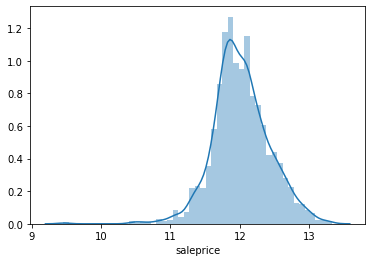

In [100]:
sns.distplot(y)

In [101]:
X = df[features6]
y = (df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()

lr = lr.fit(X_train, y_train)

y_train_preds = (lr.predict(X_train))
y_test_preds = (lr.predict(X_test))

new_test_preds = lr.predict(test_df[features6])

print(f'train RMSE:  {np.sqrt(mean_squared_error(y_train, y_train_preds))}')
print(f'test RMSE:  {np.sqrt(mean_squared_error(y_test, y_test_preds))}')

train RMSE:  23224.32921448613
test RMSE:  28599.525708112116


In [102]:
lr.score(X_train, y_train)

0.9056605749146763

In [103]:
lr.score(X_test, y_test)

0.8876669426169213

In [104]:
list = [np.round(i, 2) for i in lr.coef_]

In [105]:
list[3]

11096.7

In [106]:
for i in range(len(features6)):
    print(features6[i])
    print(list[i])
    print("--------------------")

total_bsmt_sf
29.99
--------------------
gr_liv_area
49.19
--------------------
kitchen_qual_2
0.0
--------------------
kitchen_qual_3
11096.7
--------------------
kitchen_qual_4
18678.59
--------------------
kitchen_qual_5
48610.25
--------------------
exter_qual_3
14942.89
--------------------
exter_qual_4
20636.44
--------------------
exter_qual_5
51614.45
--------------------
garage_area
43.1
--------------------
cbrt_home_age
-6948.02
--------------------
fireplaces
8957.59
--------------------
neighborhood_blueste
1605.57
--------------------
neighborhood_brdale
10037.92
--------------------
neighborhood_brkside
22349.7
--------------------
neighborhood_clearcr
13092.44
--------------------
neighborhood_collgcr
16828.9
--------------------
neighborhood_crawfor
38328.32
--------------------
neighborhood_edwards
6800.84
--------------------
neighborhood_gilbert
15358.51
--------------------
neighborhood_greens
14268.12
--------------------
neighborhood_grnhill
125520.43
-----------